# 1. ETL, Extracción Transformación y Carga de Datos

En este proceso extraemos los datos necesarios y los limpiamos para tenerlos en formato correcto para nuestros fines.

#### 1.0 Importamos librerías, definimos funciones y constantes

In [1]:
import pandas as pd
import json
import ast
import warnings
from io import StringIO
import hashlib
import matplotlib.pyplot as plt

from typing import List, Dict
import base64, csv

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import plotly.express as px
import seaborn as sns
import importlib

warnings.filterwarnings('ignore')

In [2]:

def showPie(columna):
  count_values = pd.Series(columna).value_counts()
  if len(count_values) > 15:
    count_values = count_values.iloc[0:15]
  datos = pd.DataFrame({"valor":count_values.index, "ocurrencia": count_values.values})

  plt.title(columna.name)
  plt.pie(datos["ocurrencia"], labels=datos['valor'], autopct='%1.1f%%')
  plt.show()

def concatenar(data_1, data_2,  axis=1):
  return pd.concat([data_1, data_2], axis=axis)

def contar_nulos(data):
  return data.isna().sum()

def mapear(columna: pd.Series, mapa={'NO': 0, 'SI':1}):
  return columna.map(mapa)

def showPiePx(columna, max=15):
  count_values = pd.Series(columna).value_counts()
  if len(count_values) > max:
    count_values = count_values.iloc[0:max]
  datos = pd.DataFrame({"valor":count_values.index, "ocurrencia": count_values.values})
  fig = px.pie(datos, values='ocurrencia', names='valor', title=columna.name)
  fig.update_traces(textposition='outside', textinfo='percent+label')
  fig.show()
  
def nulos_filas(data):
    return pd.DataFrame(data.isna().sum(axis=1).value_counts().sort_values(ascending=False).reset_index().values, columns=['cant_col_nulas', 'cantidad'])
  
def limpiar_funny(x: str)->int:
  temp = len(x)
  if temp == 0:
    return 0
  n = x.split(' ')[0]
  n = n.replace(',','')
  return int(n)

def limpiar_helpful(x: str)->float:
  if x == 'No ratings yet':
    return 1
  ns = x.split(' ')[:3]
  n1 = float(ns[0].replace(',',''))
  n2 = float(ns[2].replace(',',''))
  if ns[0] == 0:
    return -1.0
  return (n1/n2)

import string

def limpiar_posted(posted):
  posted = posted[7:-1].translate(str.maketrans('', '', string.punctuation))
  temp = posted.split()
  mes = temp[0]
  dia = temp[1]
  try:
    anio = temp[2]
  except:
    anio = '2016'

  return pd.to_datetime("-".join([dia, mes, anio]))

  import matplotlib.pyplot as plt

def showPie(columna, max=15):
  count_values = pd.Series(columna).value_counts()
  if len(count_values) > max:
    count_values = count_values.iloc[0:max]
  datos = pd.DataFrame({"valor":count_values.index, "ocurrencia": count_values.values})

  plt.title(columna.name)
  plt.pie(datos["ocurrencia"], labels=datos['valor'], autopct='%1.1f%%')
  plt.show()

In [3]:
URL_STEAM_GAMES = 'datasets/origin/output_steam_games.json'
URL_USERS_ITEMS = 'datasets/origin/australian_users_items.json'
URL_USERS_REVIEWS = 'datasets/origin/australian_user_reviews.json'

## 1.1 ETL del Dataset Steam Games

### 1.1.1 Leer archivo JSON

Ya que el archivo se encuentra en formato JSON, con llamar a la función built-in ```read_json()``` podemos crear un ```DataFrame``` para leer los valores.

In [4]:
df_games_all = pd.read_json(URL_STEAM_GAMES, lines=True)

### 1.1.2 Análisis de Valores Nulos

In [5]:
# Devuelve la cantidad filas que tienen la por cantidad de columnas nulas, es decir, 
# hay 88.310 filas que tienen 13 valores nulos, hay 22.530 filas que tienen 0 valores nulos

nulos_filas(df_games_all)

,cant_col_nulas,cantidad
0,13,88310
1,0,22530
2,1,6070
3,5,1940
4,3,733
5,4,391
6,2,349
7,6,121
8,10,1


Revisando los valores nulos a lo largo del eje 1, vemos que hay un número muy grande (88310) de filas completamente vacías, ya que tiene 13 columnas el dataset y la cuenta de nulos es igual a ese valor. Por lo tanto, se recorta 
hasta n-1 valores nulos, es decir, como mínimo tiene que tener una columna no nula.

In [6]:
n = len(df_games_all.columns)

df_games = df_games_all.drop( df_games_all[df_games_all.isna().sum(axis=1) > (n - 1) ].index)

### 1.1.3 Verificar duplicados

In [7]:
# Utilizamos una funcion de hash para verificar los duplicados por fila

# Convert DataFrame to string representation
df_str = df_games.astype(str).duplicated()

print(f'Cantidad de filas duplicadas: {df_str.sum()}')


Cantidad de filas duplicadas: 0


### 1.1.4 Analizar todas las columnas para quitar redundancias e información no útil para el análisis

Las columnas ```title``` y ```app_name``` parecen contener lo mismo, comparamos

In [8]:
df_games[['title','app_name']].isna().sum()

title       2050
app_name       2
dtype: int64

Las columnas ```url```, ```reviewes_url```, ```specs``` contienen información considerada superflua para el análisis, ```publisher``` duplica información, al igual que ```early_access```.

In [9]:
columnas_a_quitar = ['title','url','reviews_url', 'early_access', 'publisher', 'specs']

In [10]:
df_games.drop(columnas_a_quitar, axis=1, inplace=True)

Reorganizamos las columnas a comodidad

In [11]:
df_games = df_games[['id','app_name', 'genres', 'release_date', 'tags', 'price', 'developer']]

Seguimos trabajando con las columnas

#### 1.2.4.1. ```App_Name``` y ```Title```

In [12]:
df_games[df_games.app_name.isna()]

,id,app_name,genres,release_date,tags,price,developer
88384,NaN,None,None,None,None,19.99,None
90890,317160.0,None,"[Action, Indie]",2014-08-26,"[Action, Indie]",None,None


In [13]:
try:
    df_games.drop(88384, inplace=True)
except:
    print('No encontrado')

Buscando en la información duplicada que no usaremos para el análisis, pero la tenemos disponibles, conseguimos el valor en la columna ```title```

In [14]:
df_games.loc[90890, 'app_name'] = 'Duet'
df_games.loc[90890]

id                     317160.0
app_name                   Duet
genres          [Action, Indie]
release_date         2014-08-26
tags            [Action, Indie]
price                      None
developer                  None
Name: 90890, dtype: object

#### 1.2.4.2 ```Id```

In [15]:
df_games[df_games.id.isna()]

,id,app_name,genres,release_date,tags,price,developer
119271,NaN,Batman: Arkham City - Game of the Year Edition,"[Action, Adventure]",2012-09-07,"[Action, Open World, Batman, Adventure, Stealt...",19.99,"Rocksteady Studios,Feral Interactive (Mac)"


Al igual que hicimos anteriormente encontramos el valor en columnas que duplican información

In [16]:
df_games.loc[119271,'id'] = 200260

Ahora consideramos que es apto resetear el índice

In [17]:
df_games.reset_index(inplace=True)

In [18]:
df_games.drop('index', axis=1, inplace=True)

In [19]:
df_games

,id,app_name,genres,release_date,tags,price,developer
0,761140.0,Lost Summoner Kitty,"[Action, Casual, Indie, Simulation, Strategy]",2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.99,Kotoshiro
1,643980.0,Ironbound,"[Free to Play, Indie, RPG, Strategy]",2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",Free To Play,Secret Level SRL
2,670290.0,Real Pool 3D - Poolians,"[Casual, Free to Play, Indie, Simulation, Sports]",2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",Free to Play,Poolians.com
3,767400.0,弹炸人2222,"[Action, Adventure, Casual]",2017-12-07,"[Action, Adventure, Casual]",0.99,彼岸领域
4,773570.0,Log Challenge,None,None,"[Action, Indie, Casual, Sports]",2.99,None
...,...,...,...,...,...,...,...
32129,773640.0,Colony On Mars,"[Casual, Indie, Simulation, Strategy]",2018-01-04,"[Strategy, Indie, Casual, Simulation]",1.99,"Nikita ""Ghost_RUS"""
32130,733530.0,LOGistICAL: South Africa,"[Casual, Indie, Strategy]",2018-01-04,"[Strategy, Indie, Casual]",4.99,Sacada
32131,610660.0,Russian Roads,"[Indie, Racing, Simulation]",2018-01-04,"[Indie, Simulation, Racing]",1.99,Laush Dmitriy Sergeevich
32132,658870.0,EXIT 2 - Directions,"[Casual, Indie]",2017-09-02,"[Indie, Casual, Puzzle, Singleplayer, Atmosphe...",4.99,"xropi,stev3ns"


Buscamos items duplicados

In [20]:
cuenta_duplicados = df_games.id.value_counts()
id_dups = cuenta_duplicados[cuenta_duplicados.values > 1].keys()



In [21]:
to_b = []

for i in id_dups:
  to_b.append(df_games[df_games['id'] == i].id.idxmax())

df_games.drop(to_b, axis=0, inplace=True)

In [22]:
df_games = df_games.set_index(df_games['id'].astype(int))
df_games.id = df_games.id.astype(int)
df_games.rename_axis('index')

,id,app_name,genres,release_date,tags,price,developer
index,,,,,,,
761140,761140,Lost Summoner Kitty,"[Action, Casual, Indie, Simulation, Strategy]",2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.99,Kotoshiro
643980,643980,Ironbound,"[Free to Play, Indie, RPG, Strategy]",2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",Free To Play,Secret Level SRL
670290,670290,Real Pool 3D - Poolians,"[Casual, Free to Play, Indie, Simulation, Sports]",2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",Free to Play,Poolians.com
767400,767400,弹炸人2222,"[Action, Adventure, Casual]",2017-12-07,"[Action, Adventure, Casual]",0.99,彼岸领域
773570,773570,Log Challenge,None,None,"[Action, Indie, Casual, Sports]",2.99,None
...,...,...,...,...,...,...,...
773640,773640,Colony On Mars,"[Casual, Indie, Simulation, Strategy]",2018-01-04,"[Strategy, Indie, Casual, Simulation]",1.99,"Nikita ""Ghost_RUS"""
733530,733530,LOGistICAL: South Africa,"[Casual, Indie, Strategy]",2018-01-04,"[Strategy, Indie, Casual]",4.99,Sacada
610660,610660,Russian Roads,"[Indie, Racing, Simulation]",2018-01-04,"[Indie, Simulation, Racing]",1.99,Laush Dmitriy Sergeevich


#### 1.2.4.3 ``` Price ```

In [23]:
def isnumber(x):
    try:
        x = float(x)
        return x
    except:
        return 0

In [24]:
### Transformamos los valores a número, ```Free to Play = 0 ```

df_games.price = df_games.price.apply(isnumber)

#### 1.2.4.4 ```release_date``` y ```release_year```

In [25]:
# to_date = lambda x: pd.to_datetime(x, errors='coerce') if pd.notna(x) else pd.to_datetime('1900-01-01')
# to_date = lambda x: pd.to_datetime(x, errors='coerce').fillna(pd.to_datetime('1900-01-01'))
to_date = lambda x: pd.to_datetime(x, errors='coerce')



In [26]:
fechas = df_games['release_date'].apply(to_date)


In [27]:
df_games['release_year'] = df_games['release_date'].apply(to_date)

In [28]:
df_games['release_year'] = df_games['release_year'].dt.year.fillna(1900).astype(int)

In [29]:
df_games

,id,app_name,genres,release_date,tags,price,developer,release_year
id,,,,,,,,
761140,761140,Lost Summoner Kitty,"[Action, Casual, Indie, Simulation, Strategy]",2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.99,Kotoshiro,2018
643980,643980,Ironbound,"[Free to Play, Indie, RPG, Strategy]",2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",0.00,Secret Level SRL,2018
670290,670290,Real Pool 3D - Poolians,"[Casual, Free to Play, Indie, Simulation, Sports]",2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",0.00,Poolians.com,2017
767400,767400,弹炸人2222,"[Action, Adventure, Casual]",2017-12-07,"[Action, Adventure, Casual]",0.99,彼岸领域,2017
773570,773570,Log Challenge,None,None,"[Action, Indie, Casual, Sports]",2.99,None,1900
...,...,...,...,...,...,...,...,...
773640,773640,Colony On Mars,"[Casual, Indie, Simulation, Strategy]",2018-01-04,"[Strategy, Indie, Casual, Simulation]",1.99,"Nikita ""Ghost_RUS""",2018
733530,733530,LOGistICAL: South Africa,"[Casual, Indie, Strategy]",2018-01-04,"[Strategy, Indie, Casual]",4.99,Sacada,2018
610660,610660,Russian Roads,"[Indie, Racing, Simulation]",2018-01-04,"[Indie, Simulation, Racing]",1.99,Laush Dmitriy Sergeevich,2018


#### 1.2.4.5 ``` genres ``` y ``` tags ```

In [30]:
juego_genero = df_games['genres'].explode()

In [31]:
juego_genero

id
761140        Action
761140        Casual
761140         Indie
761140    Simulation
761140      Strategy
             ...    
610660        Racing
610660    Simulation
658870        Casual
658870         Indie
681550          None
Name: genres, Length: 74833, dtype: object

In [32]:
df_games['genres_tags'] = df_games['genres'] + df_games['tags']

In [33]:
df_games['genres_tags']	= df_games['genres_tags'].apply(lambda x: pd.Series(x).drop_duplicates().tolist())

In [34]:
# generos_tags = []
# df_games['genres_tags'].fillna("", inplace=True)
# def to_set(x):
#     try:
#         x = list(set(x))
#     except:
#         x = []
#         pass
#     return x

# df_games['genres_tags'] = df_games['genres_tags'].apply(to_set)

In [35]:
df_games['genres_tags'].explode().fillna('Generic', inplace=True)

In [36]:
print(df_games.query("id == 761140")['genres_tags'].explode())

id
761140        Action
761140        Casual
761140         Indie
761140    Simulation
761140      Strategy
Name: genres_tags, dtype: object


In [37]:
# df_games.loc[1]

In [38]:
# df_games.loc[1, 'genres_tags']

In [39]:
generos_tags = [[row['id'], *row['genres_tags']] for _, row in df_games.iterrows()]

tuplas = [[i[0], j] for i in generos_tags for j in i[1:]]

# generos_tags

In [40]:
df_juego_genero_tag = pd.DataFrame(tuplas, columns=['id_juego', 'genero_tag'])

# Elegimos el nro de generos para el dataset de análisis
nro_generos_tag = 100

recorte = df_juego_genero_tag['genero_tag'].value_counts().reset_index().head(nro_generos_tag)

df_juego_genero_tag = df_juego_genero_tag[df_juego_genero_tag.genero_tag.isin(recorte['genero_tag'])]

In [41]:
matriz_dummies = pd.get_dummies(df_juego_genero_tag, dtype=int, prefix='gen').groupby('id_juego').sum()

In [42]:
matriz_dummies.sum().sort_values(ascending=False)

gen_Indie                16352
gen_Action               11898
gen_Adventure             9221
gen_Casual                8879
gen_Strategy              7365
                         ...  
gen_Party-Based RPG        264
gen_Walking Simulator      262
gen_Colorful               260
gen_Fighting               251
gen_Rogue-lite             250
Length: 100, dtype: int64

In [43]:
filter_games_df = None

items_reviews_filter = False

if items_reviews_filter:
    items_unicos = pd.read_csv('id_items_unicos.csv')
    items_unicos.columns = ['index', 'id_juego']
    # matriz_dummies = pd.merge(matriz_dummies, items_unicos,left_on='id_juego', right_on='id_juego')
    filter_games_df = items_unicos

In [44]:
stats_filter = True

if stats_filter:
    stats = pd.read_csv('df_games_stats_user.csv')
    # stats.set_index('item_id', inplace=True)
    # stats.rename_axis('id_juego', inplace=True)
    stats.rename({'item_id': 'id_juego'}, axis=1, inplace=True)
    filter_games_df = stats
    print(stats.iloc[0])

user_id             -AnimeIsMyThing-
id_juego                       10090
playtime_forever                1373
playtime_2weeks                    0
total_play                      1373
Name: 0, dtype: object


In [45]:
if filter_games_df is not None and not filter_games_df.empty:
    matriz_dummies = pd.merge(matriz_dummies, filter_games_df, left_on='id_juego', right_on='id_juego')

matriz_dummies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 560849 entries, 0 to 560848
Columns: 105 entries, id_juego to total_play
dtypes: int32(100), int64(4), object(1)
memory usage: 235.3+ MB


In [46]:
df_games.genres.explode().rename_axis('id_juego')


id_juego
761140        Action
761140        Casual
761140         Indie
761140    Simulation
761140      Strategy
             ...    
610660        Racing
610660    Simulation
658870        Casual
658870         Indie
681550          None
Name: genres, Length: 74833, dtype: object

In [47]:
stats = pd.read_csv('df_games_stats_user.csv')
pd.merge(stats, df_games.genres.explode().rename_axis('id_juego'), left_on='item_id', right_on='id_juego').groupby(['user_id', 'genres']).sum()

item_id  playtime_forever  playtime_2weeks  \
user_id        genres                                                     
765611980577   Action        4740090               929                0   
               Adventure      634240               125                0   
               Casual         609320               743                0   
               Early Access   391460                 1                0   
               Free to Play  4071880               600                0   
...                              ...               ...              ...   
zyxwvutsrqponm RPG           1494150              7691                0   
               Simulation    1462520              5423                0   
               Sports          31280                43                0   
               Strategy      2042390             25265               44   
               Utilities      282660                 0                0   

                             total_play  
user_id        genres                    
765611980577   Action               929  
               Adventure            125  
               Casual               743  
               Early Access           1  
               Free to Play         600  
...                                 ...  
zyxwvutsrqponm RPG                 7691  
               Simulation          5423  
               Sports                43  
               Strategy           25309  
               Utilities              0  

[69580 rows x 4 columns]

In [48]:
df_games[ 'genres'].explode()

id
761140        Action
761140        Casual
761140         Indie
761140    Simulation
761140      Strategy
             ...    
610660        Racing
610660    Simulation
658870        Casual
658870         Indie
681550          None
Name: genres, Length: 74833, dtype: object

In [49]:
genero_año = pd.merge(df_games[ 'genres'].explode(), df_games[ 'release_year'].explode(), left_on='id', right_on='id')

In [50]:
pd.merge(stats, genero_año, left_on='item_id', right_on='id').groupby(['release_year','user_id', 'genres']).sum(['playtime_forever'])

item_id  playtime_forever  \
release_year user_id           genres                                    
1900         76561198053071988 Action         202170              1032   
                               Adventure      202170              1032   
             76561198053521572 Action         202170              1255   
                               Adventure      202170              1255   
             76561198053685392 Action         202170                 1   
...                                              ...               ...   
2018         rawrvixen         Indie         1121150               251   
                               RPG            642630               185   
                               Simulation     412250               251   
             runnerofchaos     Early Access   406090                 0   
                               Indie          406090                 0   

                                             playtime_2weeks  total_play  
release_year user_id           genres                                     
1900         76561198053071988 Action                      0        1032  
                               Adventure                   0        1032  
             76561198053521572 Action                      0        1255  
                               Adventure                   0        1255  
             76561198053685392 Action                      0           1  
...                                                      ...         ...  
2018         rawrvixen         Indie                       0         251  
                               RPG                         0         185  
                               Simulation                  0         251  
             runnerofchaos     Early Access                0           0  
                               Indie                       0           0  

[413539 rows x 4 columns]

In [51]:
df_juego_genero = pd.DataFrame(juego_genero)

df_juego_genero.rename_axis('id_juego', inplace=True)

In [52]:
df_games['id_juego'] = df_games['id']

matriz_generos = pd.merge(df_juego_genero, filter_games_df, left_on='id_juego', right_on='id_juego')

In [53]:
matriz_generos

,id_juego,genres,user_id,playtime_forever,playtime_2weeks,total_play
0,282010,Action,666NeCrO,261,0,261
1,282010,Action,76561197962104795,0,0,0
2,282010,Action,76561197974288321,14,0,14
3,282010,Action,76561197975369524,3,0,3
4,282010,Action,76561197977767929,100,0,100
...,...,...,...,...,...,...
1381436,80,Action,zOOyOrK187,5,0,5
1381437,80,Action,zaintheking,0,0,0
1381438,80,Action,zandado,0,0,0
1381439,80,Action,zaper151,23,0,23


In [54]:
df_games_join = df_games[['genres', 'release_year', 'id_juego']]

In [55]:
genero_estadisticas = pd.merge(matriz_generos, df_games_join, left_on='id_juego', right_on='id_juego').groupby(['genres_x', 'release_year']).count()
# genero_estadisticas.drop(columns=['id', 'app_name', 'genres_y', 'release_date', 'tags', 'price', 'developer', 'genres_tags'], inplace=True)
genero_estadisticas.to_csv('generos_estadisticas.csv')
# genero_estadisticas.drop(columns=['id'], inplace=True)
genero_estadisticas.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 353 entries, ('Action', 1900) to ('Web Publishing', 2017)
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   id_juego          353 non-null    int64
 1   user_id           353 non-null    int64
 2   playtime_forever  353 non-null    int64
 3   playtime_2weeks   353 non-null    int64
 4   total_play        353 non-null    int64
 5   genres_y          353 non-null    int64
dtypes: int64(6)
memory usage: 17.6+ KB


In [56]:
genero_estadisticas = pd.read_csv('generos_estadisticas.csv')
genero_estadisticas = genero_estadisticas.set_index('genres_x')
genero_estadisticas

,release_year,id_juego,user_id,playtime_forever,playtime_2weeks,total_play,genres_y
genres_x,,,,,,,
Action,1900,531,531,531,531,531,531
Action,1983,22,22,22,22,22,22
Action,1984,4,4,4,4,4,4
Action,1988,31,31,31,31,31,31
Action,1989,11,11,11,11,11,11
...,...,...,...,...,...,...,...
Web Publishing,2013,156,156,156,156,156,156
Web Publishing,2014,40,40,40,40,40,40
Web Publishing,2015,38,38,38,38,38,38


In [57]:
genero_estadisticas = pd.read_csv('generos_estadisticas.csv')
genero_estadisticas = genero_estadisticas.set_index(['genres_x', 'release_year'])

genero_string = 'Web Publishing'

año_maximo = genero_estadisticas.query(f"genres_x == '{genero_string}'")['playtime_forever'].sort_values(ascending=False).head(1)

pd.DataFrame(año_maximo).reset_index().release_year.values[0]

2012

In [58]:
matriz_dummies

,id_juego,gen_2D,gen_4 Player Local,gen_Action,gen_Action RPG,gen_Adventure,gen_Anime,gen_Arcade,gen_Atmospheric,gen_Building,...,gen_Violent,gen_Visual Novel,gen_Walking Simulator,gen_War,gen_Web Publishing,gen_Zombies,user_id,playtime_forever,playtime_2weeks,total_play
0,10,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,-GM-Dragon,14,0,14
1,10,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,00690069006900,0,0,0
2,10,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,110321565469,37,0,37
3,10,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1122305938,0,0,0
4,10,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,117331,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
560844,527810,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,heavykiinthesandvichborn,0,0,0
560845,527810,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,phrostb,0,0,0
560846,527900,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,76561198159037032,44,44,88
560847,530720,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,CSMisBeast,0,0,0


In [59]:
df_games.query('release_year > 2016')

,id,app_name,genres,release_date,tags,price,developer,release_year,genres_tags,id_juego
id,,,,,,,,,,
761140,761140,Lost Summoner Kitty,"[Action, Casual, Indie, Simulation, Strategy]",2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.99,Kotoshiro,2018,"[Action, Casual, Indie, Simulation, Strategy]",761140
643980,643980,Ironbound,"[Free to Play, Indie, RPG, Strategy]",2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",0.00,Secret Level SRL,2018,"[Free to Play, Indie, RPG, Strategy, Card Game...",643980
670290,670290,Real Pool 3D - Poolians,"[Casual, Free to Play, Indie, Simulation, Sports]",2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",0.00,Poolians.com,2017,"[Casual, Free to Play, Indie, Simulation, Spor...",670290
767400,767400,弹炸人2222,"[Action, Adventure, Casual]",2017-12-07,"[Action, Adventure, Casual]",0.99,彼岸领域,2017,"[Action, Adventure, Casual]",767400
772540,772540,Battle Royale Trainer,"[Action, Adventure, Simulation]",2018-01-04,"[Action, Adventure, Simulation, FPS, Shooter, ...",3.99,Trickjump Games Ltd,2018,"[Action, Adventure, Simulation, FPS, Shooter, ...",772540
...,...,...,...,...,...,...,...,...,...,...
745400,745400,Kebab it Up!,"[Action, Adventure, Casual, Indie]",2018-01-04,"[Action, Indie, Casual, Violent, Adventure]",1.99,Bidoniera Games,2018,"[Action, Adventure, Casual, Indie, Violent]",745400
773640,773640,Colony On Mars,"[Casual, Indie, Simulation, Strategy]",2018-01-04,"[Strategy, Indie, Casual, Simulation]",1.99,"Nikita ""Ghost_RUS""",2018,"[Casual, Indie, Simulation, Strategy]",773640
733530,733530,LOGistICAL: South Africa,"[Casual, Indie, Strategy]",2018-01-04,"[Strategy, Indie, Casual]",4.99,Sacada,2018,"[Casual, Indie, Strategy]",733530


In [60]:
# matriz_dummies_rev.to_csv('matriz_dummies_rev.csv')

In [61]:
# matriz_dummies.to_csv('md.csv')

In [62]:
matriz_dummies.index = matriz_dummies.index.astype(int)

to_drop = matriz_dummies.sum()[matriz_dummies.sum() == 0].index.to_list()

matriz_dummies.drop(to_drop, axis=1, inplace=True)

TypeError: can only concatenate str (not "int") to str

In [ ]:
matriz_dummies

In [ ]:
matriz_dummies.rename_axis('index', inplace=True)

In [ ]:
matriz_dummies.index = matriz_dummies.id_juego.astype(int)

In [ ]:
matriz_dummies.columns

Index(['id_juego', 'gen_2D', 'gen_Action', 'gen_Adventure', 'gen_Anime',
       'gen_Arcade', 'gen_Atmospheric', 'gen_Casual', 'gen_Classic',
       'gen_Co-op', 'gen_Difficult', 'gen_Early Access', 'gen_FPS',
       'gen_Fantasy', 'gen_Female Protagonist', 'gen_First-Person',
       'gen_Free to Play', 'gen_Funny', 'gen_Great Soundtrack', 'gen_Horror',
       'gen_Indie', 'gen_Massively Multiplayer', 'gen_Multiplayer',
       'gen_Open World', 'gen_Pixel Graphics', 'gen_Platformer',
       'gen_Point & Click', 'gen_Puzzle', 'gen_RPG', 'gen_Racing', 'gen_Retro',
       'gen_Sandbox', 'gen_Sci-fi', 'gen_Shooter', 'gen_Simulation',
       'gen_Singleplayer', 'gen_Sports', 'gen_Story Rich', 'gen_Strategy',
       'gen_Survival', 'gen_Turn-Based', 'playtime_forever', 'playtime_2weeks',
       'total_play'],
      dtype='object')

In [ ]:
matriz_dummies = matriz_dummies.drop(matriz_dummies.columns[[0, -1, -2, -3]], axis=1)

In [ ]:
matriz_dummies.to_csv('matriz_dummies.csv')

In [ ]:
matriz_dummies.sample(2)

,gen_2D,gen_Action,gen_Adventure,gen_Anime,gen_Arcade,gen_Atmospheric,gen_Casual,gen_Classic,gen_Co-op,gen_Difficult,...,gen_Sandbox,gen_Sci-fi,gen_Shooter,gen_Simulation,gen_Singleplayer,gen_Sports,gen_Story Rich,gen_Strategy,gen_Survival,gen_Turn-Based
id_juego,,,,,,,,,,,,,,,,,,,,,
300080,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,1,0,0
280460,1,1,0,0,1,1,0,0,1,1,...,0,1,1,0,1,0,0,0,0,0


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

def comparar(id_1, id_2):
    row1 = matriz_dummies.loc[id_1].values.reshape(1,-1)
    row2 = matriz_dummies.loc[id_2].values.reshape(1,-1)
    return cosine_similarity(row1, row2)    


In [ ]:
def get_recommended(id_juego):
    lista = []
    # id_juego = matriz_dummies.sample().index

    for i in matriz_dummies.index.tolist():
        if i != id_juego:
            (a, b) = i, comparar(id_juego, i)
            if 0.5 < b[0][0] <= 1:
                lista.append((a, b[0][0]))
    
    return pd.DataFrame(lista, columns=['id_juego', 'similitud']).sort_values('similitud', ascending=False).head(5)
    

In [ ]:
id_juego = 30

# pd.DataFrame(lista, columns=['id_juego', 'similitud']).sort_values('similitud', ascending=False).head(5)

get_recommended(id_juego)

,id_juego,similitud
118,13540,1.000000
258,209160,0.935414
52,3700,0.935414
188,38430,0.935414
145,20530,0.875000


In [ ]:
# big = cosine_similarity(matriz_dummies,matriz_dummies)

In [ ]:
# big[0:5, 0: 5]

In [ ]:
generos_filtrados = df_juego_genero_tag['genero_tag'].value_counts().head(50).reset_index().head(38)['genero_tag'].to_list()

In [ ]:
mask = df_juego_genero_tag['genero_tag'].isin(generos_filtrados)

In [ ]:
df_juego_genero_tag['genero_tag'][mask]

0               Action
1               Casual
2                Indie
3           Simulation
4             Strategy
              ...     
159282          Casual
159283           Indie
159284          Puzzle
159285    Singleplayer
159286     Atmospheric
Name: genero_tag, Length: 110776, dtype: object

In [ ]:
a_clustear = pd.get_dummies(df_juego_genero_tag['genero_tag'][mask], dtype='int')

In [ ]:
a_clustear

,2D,Action,Adventure,Anime,Arcade,Atmospheric,Casual,Co-op,Difficult,Early Access,...,Retro,Sandbox,Sci-fi,Shooter,Simulation,Singleplayer,Sports,Story Rich,Strategy,Turn-Based
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159282,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
159283,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
159284,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
159285,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [ ]:
df_games.query('id == 12500')

,id,app_name,genres,release_date,tags,price,developer,release_year,genres_tags,id_juego
id,,,,,,,,,,
12500,12500,PuzzleQuest: Challenge of the Warlords,[Casual],2007-10-10,"[Puzzle, Casual, Match 3, RPG, Fantasy, 2D, St...",9.99,Infinite Interactive,2007,"[Casual, Puzzle, Match 3, RPG, Fantasy, 2D, St...",12500


In [ ]:
from sklearn.cluster import KMeans
import numpy as np

# Assuming you have your data stored in a variable called 'data'

# Create a KMeans instance with 38 clusters
kmeans = KMeans(n_clusters=38)

# Fit the KMeans model to your data
kmeans.fit(a_clustear)

# Get the cluster labels for each data point
cluster_labels = kmeans.labels_

# Get the cluster centers
cluster_centers = kmeans.cluster_centers_

In [ ]:
preds = kmeans.predict(a_clustear)

preds.shape

(110776,)

In [ ]:
df_recortado =df_games.query("release_year.notnull()")


In [ ]:
df_recortado['release_year'] = df_recortado['release_year'].astype(int)

In [ ]:
df_recortado.query("id == 12500")

,id,app_name,genres,release_date,tags,price,developer,release_year,genres_tags,id_juego
id,,,,,,,,,,
12500,12500,PuzzleQuest: Challenge of the Warlords,[Casual],2007-10-10,"[Puzzle, Casual, Match 3, RPG, Fantasy, 2D, St...",9.99,Infinite Interactive,2007,"[Casual, Puzzle, Match 3, RPG, Fantasy, 2D, St...",12500


In [ ]:
df_recortado.index = df_recortado.index.astype(int)

In [ ]:
df_recortado['id'] = df_recortado['id'].astype(int)

In [ ]:
df_recortado.drop('id', axis=1)

,app_name,genres,release_date,tags,price,developer,release_year,genres_tags,id_juego
id,,,,,,,,,
761140,Lost Summoner Kitty,"[Action, Casual, Indie, Simulation, Strategy]",2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.99,Kotoshiro,2018,"[Action, Casual, Indie, Simulation, Strategy]",761140
643980,Ironbound,"[Free to Play, Indie, RPG, Strategy]",2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",0.00,Secret Level SRL,2018,"[Free to Play, Indie, RPG, Strategy, Card Game...",643980
670290,Real Pool 3D - Poolians,"[Casual, Free to Play, Indie, Simulation, Sports]",2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",0.00,Poolians.com,2017,"[Casual, Free to Play, Indie, Simulation, Spor...",670290
767400,弹炸人2222,"[Action, Adventure, Casual]",2017-12-07,"[Action, Adventure, Casual]",0.99,彼岸领域,2017,"[Action, Adventure, Casual]",767400
773570,Log Challenge,None,None,"[Action, Indie, Casual, Sports]",2.99,None,1900,[nan],773570
...,...,...,...,...,...,...,...,...,...
773640,Colony On Mars,"[Casual, Indie, Simulation, Strategy]",2018-01-04,"[Strategy, Indie, Casual, Simulation]",1.99,"Nikita ""Ghost_RUS""",2018,"[Casual, Indie, Simulation, Strategy]",773640
733530,LOGistICAL: South Africa,"[Casual, Indie, Strategy]",2018-01-04,"[Strategy, Indie, Casual]",4.99,Sacada,2018,"[Casual, Indie, Strategy]",733530
610660,Russian Roads,"[Indie, Racing, Simulation]",2018-01-04,"[Indie, Simulation, Racing]",1.99,Laush Dmitriy Sergeevich,2018,"[Indie, Racing, Simulation]",610660


In [ ]:
items_unicos = pd.read_csv('id_items_unicos.csv')
items_unicos.columns = ['index', 'id_juego']

items_unicos

,index,id_juego
0,0,1250
1,1,22200
2,2,43110
3,3,251610
4,4,227300
...,...,...
3677,3677,307130
3678,3678,209120
3679,3679,220090
3680,3680,262850


In [ ]:
df_recortado_2 = pd.merge(items_unicos, df_recortado.drop('id', axis=1), left_on='id_juego', right_on='id')

In [ ]:
df_recortado_2.query("app_name.str.contains('boid')")


,index,id_juego_x,app_name,genres,release_date,tags,price,developer,release_year,genres_tags,id_juego_y
281,318,108600,Project Zomboid,"[Indie, RPG, Simulation, Early Access]",2013-11-08,"[Early Access, Survival, Zombies, Open World, ...",14.99,The Indie Stone,2013,"[Indie, RPG, Simulation, Early Access, Surviva...",108600


In [ ]:
# lista_comp = []
# for i in matriz_dummies.index:
#     temp = []
#     for j in matriz_dummies.index:
#         temp.append(comparar(i,j))
#     lista_comp.append(temp)


In [ ]:
# matriz = pd.DataFrame(lista_comp)

# matriz.to_csv('matrizon.csv')

In [ ]:
def comparar(id_1, id_2):
    row1 = matriz_dummies.loc[id_1].values.reshape(1, -1)
    row2 = matriz_dummies.loc[id_2].values.reshape(1, -1)
    return cosine_similarity(row1, row2)    


matriz_dummies = pd.read_csv('matriz_dummies.csv', index_col='id_juego')

lista = []
id_juego = matriz_dummies.sample().index

# if id_juego not in matriz_dummies:
#     return {'message' : 'game_id not found!!!'}

for i in matriz_dummies.index.tolist():
    if i != id_juego:
        (a, b) = i, comparar(id_juego, i)
        if 0.5 < b[0][0] <= 1:
            lista.append((a, b[0][0]))

juegos_rec = pd.DataFrame(lista, columns=['id_juego', 'similitud']).sort_values('similitud', ascending=False).head(5)

In [ ]:
juegos_rec

,id_juego,similitud
114,254840,1.000000
8,3230,1.000000
140,289500,1.000000
133,281390,1.000000
202,386840,0.816497


## 1.2 User Items

#### 1. Cargamos el contenido del Archivo User's Items en un arreglo de líneas con codigo JSON en formato de String

In [ ]:
df_games.query("id= '73190'")

In [ ]:
lines_items = []
json_lines_items = []

with open(URL_USERS_ITEMS, 'r', encoding='utf-8') as f_items:
    for line in f_items:
        lines_items.append(line)

In [ ]:
len(lines_items)

88310

In [ ]:
linea_1 = json.dumps(ast.literal_eval(lines_items[0]))

In [ ]:
json_linea_1 = json.dumps(ast.literal_eval(linea_1))

In [ ]:
pd.read_json(json_linea_1, lines=True)

,user_id,items_count,steam_id,user_url,items
0,76561197970982480,277,76561197970982480,http://steamcommunity.com/profiles/76561197970...,"[{'item_id': '10', 'item_name': 'Counter-Strik..."


In [ ]:
dt_linea_1 = pd.DataFrame(ast.literal_eval(linea_1)['items'])
dt_linea_1['user_id'] = '76561197970982480'
dt_linea_1

,item_id,item_name,playtime_forever,playtime_2weeks,user_id
0,10,Counter-Strike,6,0,76561197970982480
1,20,Team Fortress Classic,0,0,76561197970982480
2,30,Day of Defeat,7,0,76561197970982480
3,40,Deathmatch Classic,0,0,76561197970982480
4,50,Half-Life: Opposing Force,0,0,76561197970982480
...,...,...,...,...,...
272,289130,Endless Legend,593,0,76561197970982480
273,268500,XCOM 2,1495,0,76561197970982480
274,461640,Sins Of The Demon RPG,0,0,76561197970982480
275,379720,DOOM,793,0,76561197970982480


In [ ]:
json_lines_items = []

In [ ]:
for i, linea in enumerate(lines_items):
  try:
    json_lines_items.append(json.dumps(ast.literal_eval(linea)))
  except:
    pass

In [ ]:
len(json_lines_items)

88310

In [ ]:
# df_users_stats = pd.read_json("\n".join(lines_items), lines=True)

df_users_stats = pd.read_json("\n".join(lines_items), lines=True)

In [ ]:
dfs = []

# Read JSON lines in chunks of 5000 lines each
chunksize = 5000
for chunk in range(0, len(json_lines_items), chunksize):
    chunk_data = "\n".join(json_lines_items[chunk:chunk + chunksize])
    df_chunk = pd.read_json(chunk_data, lines=True)
    dfs.append(df_chunk)

# Concatenate the DataFrames into a single DataFrame
df_users_stats = pd.concat(dfs, ignore_index=True)

In [ ]:
df_users_stats

,user_id,items_count,steam_id,user_url,items
0,76561197970982479,277,76561197970982480,http://steamcommunity.com/profiles/76561197970...,"[{'item_id': '10', 'item_name': 'Counter-Strik..."
1,js41637,888,76561198035864384,http://steamcommunity.com/id/js41637,"[{'item_id': '10', 'item_name': 'Counter-Strik..."
2,evcentric,137,76561198007712560,http://steamcommunity.com/id/evcentric,"[{'item_id': '1200', 'item_name': 'Red Orchest..."
3,Riot-Punch,328,76561197963445856,http://steamcommunity.com/id/Riot-Punch,"[{'item_id': '10', 'item_name': 'Counter-Strik..."
4,doctr,541,76561198002099488,http://steamcommunity.com/id/doctr,"[{'item_id': '300', 'item_name': 'Day of Defea..."
...,...,...,...,...,...
88305,76561198323066619,22,76561198323066624,http://steamcommunity.com/profiles/76561198323...,"[{'item_id': '413850', 'item_name': 'CS:GO Pla..."
88306,76561198326700687,177,76561198326700688,http://steamcommunity.com/profiles/76561198326...,"[{'item_id': '11020', 'item_name': 'TrackMania..."
88307,XxLaughingJackClown77xX,0,76561198328759264,http://steamcommunity.com/id/XxLaughingJackClo...,[]
88308,76561198329548331,7,76561198329548336,http://steamcommunity.com/profiles/76561198329...,"[{'item_id': '304930', 'item_name': 'Unturned'..."


In [ ]:
lista = []

for i in range(df_users_stats.shape[0]):
  id_usuario = df_users_stats.iloc[i,0]
  dic = df_users_stats.iloc[i,4]
  for j, it in enumerate(dic):
    item_id = dic[j]['item_id']
    item_name = dic[j]['item_name']
    item_play_time = dic[j]['playtime_forever']
    item_pt2 = dic[j]['playtime_2weeks']
    tupla = (id_usuario, item_id, item_name, item_play_time, item_pt2)
    lista.append(tupla)

In [ ]:
len(lista)

5153209

In [ ]:
columnas = ['user_id','item_id', 'item_name', 'playtime_forever', 'playtime_2weeks']

In [ ]:
df_usuarios_est = pd.DataFrame(lista, columns=columnas)

In [ ]:
df_usuarios_est = df_usuarios_est[['user_id', 'item_id', 'playtime_forever']].query("playtime_forever > 1440 and playtime_forever < 21900")

In [ ]:
# df_usuarios_est['total_play'] = df_usuarios_est['playtime_forever'] + df_usuarios_est['playtime_2weeks']

In [ ]:
df_usuarios_est.groupby(['user_id', 'item_id']).sum().to_csv('df_games_stats_user_item.csv')

In [ ]:
df_usuarios_est.item_id = df_usuarios_est.item_id.astype(int)

In [ ]:
df_usuarios_est

,user_id,item_id,playtime_forever
8,76561197970982479,300,4733
9,76561197970982479,240,1853
16,76561197970982479,6910,2685
41,76561197970982479,17460,1613
46,76561197970982479,1250,10006
...,...,...,...
5152638,76561198312638244,362890,2184
5152651,76561198313357718,730,2317
5152652,POMFP0MF,730,2987
5152671,76561198319916652,370240,1533


<Axes: xlabel='playtime_forever', ylabel='Count'>

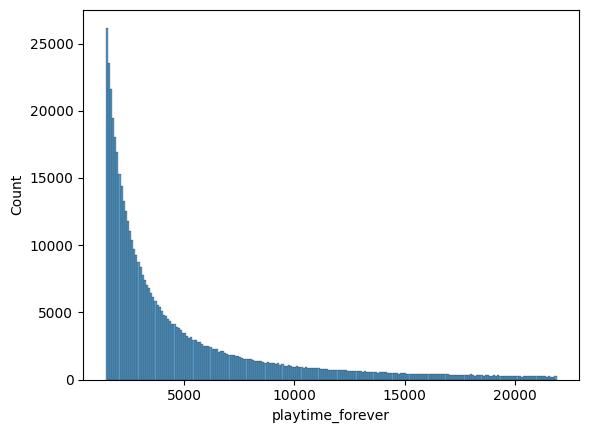

In [ ]:
sns.histplot(df_usuarios_est.playtime_forever)

In [ ]:
df_usuarios_est.query("item_id == 3900").sort_values(by='playtime_forever', ascending=False)

,user_id,item_id,playtime_forever
1035697,nipplelicker4000,3900,9339
2722033,76561197972699388,3900,9294
627144,a4nic8er,3900,9073
1826284,76561197990997704,3900,7079
416256,76561198017614917,3900,6619
...,...,...,...
2723369,iconaclysm,3900,1471
327248,76561198068689243,3900,1464
4412267,76561198048930835,3900,1458
2918257,Whoppaz,3900,1448


## 1.3 Reviews

In [ ]:
URL_USERS_REVIEWS

'datasets/origin/australian_user_reviews.json'

In [ ]:
lines_r = []

with open(URL_USERS_REVIEWS, 'rt', encoding= 'utf-8') as rev_file:
  for i, line in enumerate(rev_file):
    lines_r.append(ast.literal_eval(line))


In [ ]:
df_revs = pd.DataFrame(lines_r)

In [ ]:
columnas: List[str] = ['id_usuario', 'funny', 'posted', 'last_edited', 'item_id', 'helpful', 'recommend', 'review']

In [ ]:
columnas = ['id_usuario']
columnas.extend(df_revs.reviews[0][0].keys())

In [ ]:
lista_revs = []

for i in df_revs.index:
  id_usuario = df_revs.loc[i, 'user_id']
  dic = df_revs.loc[i, 'reviews']
  for it in dic:
    tupla = [id_usuario,*it.values()]
    lista_revs.append(tupla)

In [ ]:
df_revs = pd.DataFrame(lista_revs, columns=columnas)

In [ ]:
pd.Series(df_revs.item_id.unique()).to_csv('id_items_unicos.csv')

In [ ]:
nltk.download('vader_lexicon')

# Initialize the VADER sentiment analyzer
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\javier\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
df_revs['review_score'] = df_revs['review'].apply(lambda x: sid.polarity_scores(x)['compound'])
df_revs['review_sent'] = df_revs.review_score.apply(lambda x: 0 if x < 0 else (2 if x > 0 else 1))

df_revs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59305 entries, 0 to 59304
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id_usuario    59305 non-null  object 
 1   funny         59305 non-null  object 
 2   posted        59305 non-null  object 
 3   last_edited   59305 non-null  object 
 4   item_id       59305 non-null  object 
 5   helpful       59305 non-null  object 
 6   recommend     59305 non-null  bool   
 7   review        59305 non-null  object 
 8   review_score  59305 non-null  float64
 9   review_sent   59305 non-null  int64  
dtypes: bool(1), float64(1), int64(1), object(7)
memory usage: 4.1+ MB


In [ ]:
df_revs_clean = df_revs[['id_usuario', 'funny', 'posted','item_id', 'recommend', 'helpful', 'review_sent']]

df_revs_clean['year'] = df_revs_clean.posted.astype('str')
df_revs_clean['year'] = df_revs_clean.year.apply(lambda x: x.split('-')[0])

In [ ]:
df_revs_clean.drop('posted', axis=1)

,id_usuario,funny,item_id,recommend,helpful,review_sent,year
0,76561197970982479,,1250,True,No ratings yet,2,"Posted November 5, 2011."
1,76561197970982479,,22200,True,No ratings yet,2,"Posted July 15, 2011."
2,76561197970982479,,43110,True,No ratings yet,2,"Posted April 21, 2011."
3,js41637,,251610,True,15 of 20 people (75%) found this review helpful,2,"Posted June 24, 2014."
4,js41637,,227300,True,0 of 1 people (0%) found this review helpful,2,"Posted September 8, 2013."
...,...,...,...,...,...,...,...
59300,76561198312638244,,70,True,No ratings yet,2,Posted July 10.
59301,76561198312638244,,362890,True,No ratings yet,2,Posted July 8.
59302,LydiaMorley,1 person found this review funny,273110,True,1 of 2 people (50%) found this review helpful,2,Posted July 3.
59303,LydiaMorley,,730,True,No ratings yet,2,Posted July 20.


In [ ]:
df_revs_clean.to_csv('revs.csv', index=False)

In [ ]:
df_revs_clean.to_parquet('revs.parquet', index=False)

In [ ]:
%pip install pyarrow

In [ ]:
item_revs = df_revs_clean.groupby(['item_id']).count()['id_usuario'].sort_values(ascending=False)

In [ ]:
df_item_revs = pd.DataFrame(item_revs)

(array([843., 328., 197.,  66.,  96.,  75.,  29.,  46.,  57.,  35.]),
 array([ 2. ,  3.7,  5.4,  7.1,  8.8, 10.5, 12.2, 13.9, 15.6, 17.3, 19. ]),
 <BarContainer object of 10 artists>)

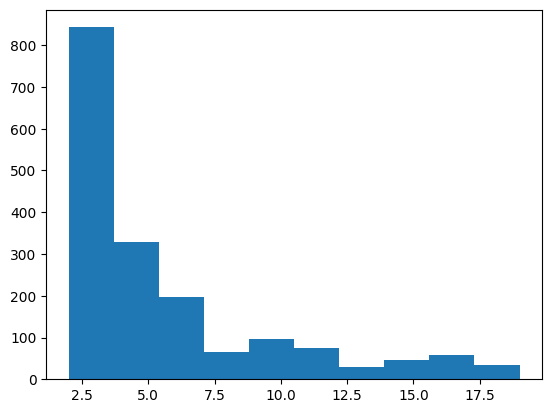

In [ ]:
plt.hist(df_item_revs[(df_item_revs.id_usuario<20) & (df_item_revs.id_usuario>1) ].id_usuario)

In [ ]:
df_item_revs

,id_usuario
item_id,
730,3759
440,3736
4000,1735
570,1562
218620,1137
...,...
342620,1
233310,1
342370,1


In [ ]:
df_revs_item_year = df_revs_clean.groupby(['item_id', 'year']).count()['id_usuario'].sort_values(ascending=False).reset_index()

In [ ]:
year = 2014
item = 440
df_revs_item_year.query(f"year == '{year}' and item_id == '{item}'")

,item_id,year,id_usuario


In [ ]:
df_revs_clean.drop('posted', axis=1)

,id_usuario,funny,item_id,recommend,helpful,review_sent,year
0,76561197970982479,,1250,True,No ratings yet,2,"Posted November 5, 2011."
1,76561197970982479,,22200,True,No ratings yet,2,"Posted July 15, 2011."
2,76561197970982479,,43110,True,No ratings yet,2,"Posted April 21, 2011."
3,js41637,,251610,True,15 of 20 people (75%) found this review helpful,2,"Posted June 24, 2014."
4,js41637,,227300,True,0 of 1 people (0%) found this review helpful,2,"Posted September 8, 2013."
...,...,...,...,...,...,...,...
59300,76561198312638244,,70,True,No ratings yet,2,Posted July 10.
59301,76561198312638244,,362890,True,No ratings yet,2,Posted July 8.
59302,LydiaMorley,1 person found this review funny,273110,True,1 of 2 people (50%) found this review helpful,2,Posted July 3.
59303,LydiaMorley,,730,True,No ratings yet,2,Posted July 20.


In [ ]:
df_revs.funny = df_revs.funny.apply(limpiar_funny)
df_revs.helpful = df_revs.helpful.apply(limpiar_helpful)
df_revs.posted = df_revs.posted.apply(limpiar_posted)
df_revs.recommend = df_revs.recommend.map({True: 1, False: 0})

In [ ]:
df_revs.head(5)

,id_usuario,funny,posted,last_edited,item_id,helpful,recommend,review,review_score,review_sent
0,76561197970982479,0,2011-11-05,,1250,1.00,1,Simple yet with great replayability. In my opi...,0.8481,2
1,76561197970982479,0,2011-07-15,,22200,1.00,1,It's unique and worth a playthrough.,0.2263,2
2,76561197970982479,0,2011-04-21,,43110,1.00,1,Great atmosphere. The gunplay can be a bit chu...,0.9117,2
3,js41637,0,2014-06-24,,251610,0.75,1,I know what you think when you see this title ...,0.9566,2
4,js41637,0,2013-09-08,,227300,0.00,1,For a simple (it's actually not all that simpl...,0.9708,2


In [ ]:
df_revs['year_posted'] = df_revs.posted.dt.year

In [ ]:
df_revs.query("item_id == '306630'").groupby(['item_id', 'year_posted']).sum(['reviews_sent', 'recommend']).sort_values(by='recommend', ascending=False)

,,funny,helpful,recommend,review_score,review_sent
item_id,year_posted,,,,,
